# Detecció d'opinions

In [70]:
# Matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# NLTK
import nltk
from nltk.corpus import movie_reviews as mr
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('movie_reviews')
nltk.download('stopwords')

# Numpy
import numpy as np

# Pandas
import pandas as pd

# Pickle
import pickle

# Sklearn
from sklearn.base import BaseEstimator
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Typing
from typing import Any, Dict, List, Tuple, Type

# DateTime
import datetime


# Requisitos para el typing
SklearnEstimator = Type[BaseEstimator]


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/barre/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to /home/barre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
corpus = mr.fileids()[0]
".".isalpha()


False

In [3]:
def preprocess(review: str)-> str:
    """
    Función que preprocesa una review del corpus.

    Parámetros:
    - review: String de una review.

    Retorna:
    - review: Una string con review preprocesada:
                - sin mayúsculas.
                - sin dígitos ni caracteres distintos a [a-z].
                - sin saltos de línea (\n).
                - lematizada cada palabra.
                - separadas por un espacio (" ").
                - sin stopwords.
    """
    review = review.lower()
    # eliminate any character that is not a letter or a space
    review = ''.join(c for c in review if c.isalpha() or c == ' ')
    review = review.replace('\n', ' ')
    # convert all the words to its lemma
    lemmatizer = nltk.WordNetLemmatizer()
    
    review = ' '.join(lemmatizer.lemmatize(word) for word in review.split())

    # remove stopwords
    stopwords = set(nltk.corpus.stopwords.words('english'))
    review = [w for w in review.split() if w not in stopwords]
    review = ' '.join(review)

    return review

def split_corpus(X: List[str], y: list, test_size = 0.2, random_state = 42) -> Tuple[List, List, List, List]:
    """
    Función que divide el corpus y el vector y en X_train, X_test, y_train y y_test.

    Parámetros:
    - x: Lista de string siendo dicha string una review preprocesada y la lista conteniendo todas ellas.
    - y: Lista compuesta de "pos" o "neg", según si la review del corpus con el mismo índice es positiva o negativa.
    - test_size: Float indicando proporción de test del corpus.
    - random_state: Número entero indicando la semilla para separar el corpus.

    Retorna: 
    - X_train
    - X_test
    - y_train
    - y_test
        -> Conjunto de X e y separadas según train y test, siendo las X (train y test) vectorizadas.
    - vectorizer: Vectorizador entrenado con las particiones de train para utilizar con el test en un futuro
    """
    vectorizer = CountVectorizer()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    return X_train, X_test, y_train, y_test, vectorizer

corpus = [preprocess(mr.raw(review)) for review in mr.fileids()]
y = ["pos"]*1000 + ["neg"]*1000 

X_train, X_test, y_train, y_test, vectorizer = split_corpus(corpus, y)


In [4]:
print(X_test)

  (0, 103)	1
  (0, 163)	1
  (0, 221)	1
  (0, 268)	1
  (0, 331)	1
  (0, 532)	1
  (0, 755)	1
  (0, 857)	2
  (0, 869)	1
  (0, 906)	1
  (0, 1008)	1
  (0, 1208)	5
  (0, 1354)	1
  (0, 1376)	1
  (0, 1385)	1
  (0, 1540)	1
  (0, 1603)	1
  (0, 1624)	1
  (0, 2180)	2
  (0, 2491)	3
  (0, 2527)	8
  (0, 2647)	1
  (0, 2667)	1
  (0, 2668)	1
  (0, 2726)	1
  :	:
  (399, 33675)	2
  (399, 34043)	1
  (399, 34182)	1
  (399, 34453)	3
  (399, 34491)	1
  (399, 34768)	1
  (399, 34785)	1
  (399, 35136)	1
  (399, 35303)	1
  (399, 35357)	1
  (399, 35362)	1
  (399, 35391)	1
  (399, 35471)	1
  (399, 35988)	2
  (399, 36108)	2
  (399, 36109)	1
  (399, 36226)	2
  (399, 36326)	1
  (399, 36483)	1
  (399, 36487)	1
  (399, 36808)	1
  (399, 36865)	1
  (399, 36990)	1
  (399, 36999)	1
  (399, 37261)	1


## MODELOS SUPERVISADOS

### Funciones para realizar búsquedas "greedy" y visualizar los resultados

In [50]:


def grid_search(classifier: BaseEstimator, classifier_str: str, params: Dict[str, List], hacer_grid_search = True, kfolds = 5) -> GridSearchCV:
    """
    Esta función realiza una búsqueda de hiperparámetros utilizando GridSearchCV y
    guarda los resultados en un archivo binario si se especifica "hacer_grid_search" como True.
    Si "hacer_grid_search" es False, carga los resultados previamente guardados del archivo binario.

    Parámetros:
    - classifier: Instancia de BaseEstimador de Sklearn.
    - classifier_str: Una cadena que representa el nombre del modelo para guardar o abrir el archivo binario, debería ser diferente para cada modelo.
    - params: Un diccionario que contiene los hiperparámetros a ajustar en el GridSearchCV.
    - hacer_grid_search: Un booleano que indica si se debe realizar una nueva búsqueda GridSearchCV
                         (predeterminado es True).
    - kfolds: Número entero (int) de subsets de validación que se utilizarán para evitar overfitting.
              Sólo se utilizará en caso de realizar la "grid_search", es decir, en caso de que "hacer_grid_search" sea True.

    Retorna:
    - grid_search_result: Una instancia de GridSearchCV que contiene los resultados de la búsqueda de hiperparámetros.
    """

    # Realizar la búsqueda en caso de que se quiera buscar con parámetros nuevos
    if hacer_grid_search:
        grid_search_result = GridSearchCV(classifier, params, cv=kfolds)
        t0 = datetime.datetime.now()
        grid_search_result.fit(X_train, y_train)
        t1 = datetime.datetime.now()
        
        # Guardar en un archivo binario la instancia de GridSearchCV ejecutada con el modelo escogido
        with open(f'./bin/{classifier_str}_grid_search.bin', "wb+") as file:
            pickle.dump(grid_search_result, file)

    # En caso de no querer realizar otra vez la búsqueda, se carga del binario
    else:
        with open(f'./bin/{classifier_str}_grid_search.bin', "rb") as file:
            grid_search_result = pickle.load(file)
    print(grid_search_result.best_params_)
    print(grid_search_result.best_score_)
    return grid_search_result



def plot_gridsearch(grid: GridSearchCV, model_str, param_grid: Dict[str, list], x, y, xlab, ylab, z=None):
    """
    Función que crea una gráfica con los resultados de la búsqueda ambiciosa.

    Parámetros:
    - grid: Instancia de GridSearchCV con la búsqueda "greedy" con distintos alpha-s.
    - model_str: String con el nombre del modelo cuya imagen de los resultados de la búsqueda se vayan a guardar en el directorio ./Images
    - param_grid: dict conteniendo las alpha-s con las que se ha realizado la búsqueda.
    - x: String con la variable de param_grid que pertenecerá al eje x.
    - y: String con la variable de param_grid que pertenecerá al eje y, normalmente la métrica de performance.
    - xlab: Label del eje x.
    - ylab: Label del eje y.
    - z: En caso de querer ver algún otro parámetro, string con el parámetro que creará líneas de distintos 
         colores para cada valor de dicho parámetro, en función de la x y la y es None por defecto. 
    
    """

    scores = grid.cv_results_[y]

    length_x = len(param_grid[x])
    if z != None:
        length_z = len(param_grid[z])
    else:
        length_z = 1

    for i in range(length_z):
        plt.plot(param_grid[x], scores[i*length_x:(i+1)*length_x])
    
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    plt.axvline(grid.best_params_[x], color='r',alpha = 0.3)
    if z!= None:
        plt.legend(param_grid[z])
    plt.savefig(f"Images/{model_str}_grid_search.png")
    plt.show()
    

In [61]:
model_list = []

***
### **Modelo Multinomial**
***

GridSearch - Realizamos una búsqueda con "cross validation" para escoger los parámetros

In [98]:
# Búsqueda greedy para escoger el mejor hiperparámetro
param_grid = {'alpha': [0.1, 0.5, 1.0, 2.0,3.0,5.0,10.0,20.0,50.0,100.0]}
grid_multinomial = grid_search(MultinomialNB(), "multinomial", param_grid, True)

{'alpha': 5.0}
0.809375


Representación gráfica de la búsqueda

{'alpha': 5.0}
0.809375


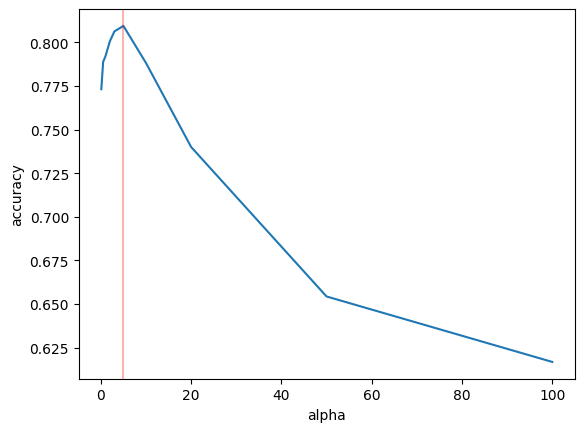

In [62]:
# Plot del accuracy en función de alpha
plot_gridsearch(grid_multinomial, "multinomial",param_grid, "alpha", "mean_test_score", "alpha", "accuracy")




Creación del modelo

In [100]:
# Creación y entrenamiento del modelo considerando la búsqueda anterior
multinomial = MultinomialNB(alpha=grid_multinomial.best_params_["alpha"])
multinomial.fit(X_train, y_train)

# Añadido a la lista de modelos
model_list.append((multinomial,"multinomial"))

***
### **Regresión Logística**
***

GridSearch - Realizamos una búsqueda con "cross validation" para escoger los parámetros

In [73]:
parameters_logreg = {'C':[0.1,1,5,10,20,30,50,75,100], "solver":["newton-cg","lbfgs", "liblinear"]}
logreg = LogisticRegression(max_iter=1000)

grid_logreg = grid_search(logreg, "log_reg", parameters_logreg, False)


{'C': 0.1, 'solver': 'newton-cg'}
0.83375


Representación gráfica de la búsqueda

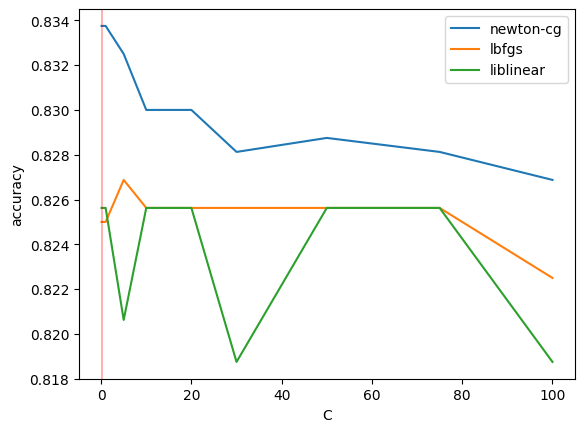

In [74]:
# plot the results of the gridsearch
plot_gridsearch(grid_logreg, "log_reg", parameters_logreg, "C", "mean_test_score", "C", "accuracy", "solver")


In [97]:
# Creación y entrenamiento del modelo considerando la búsqueda anterior
log_reg = LogisticRegression(C = grid_logreg.best_params_["C"], solver=grid_logreg.best_params_["solver"], max_iter=1000)
log_reg.fit(X_train, y_train)

# Añadido a la lista de modelos
model_list.append((log_reg,"log_reg"))

time to train: 0.395764


***
### **Support Vector Machine**
***

GridSearch - Realizamos una búsqueda con "cross validation" para escoger los parámetros

In [10]:
svc_parameters = {'kernel':('linear', 'rbf'), 'C':[0.1,1,5,10,20]}

grid_svc = grid_search(SVC(), "SVC", svc_parameters, False)

{'C': 20, 'kernel': 'rbf'}
0.8243750000000001


Representación gráfica de la búsqueda

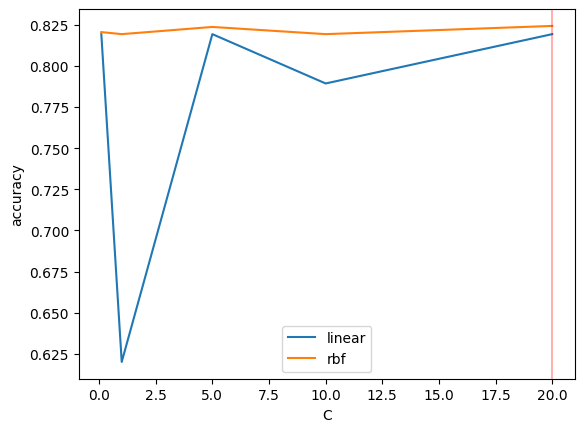

"scores = grid_svc.cv_results_['mean_test_score']\nC = [0.1,1,5,10,20]\nplt.plot(C, scores[:5])\nplt.xlabel('C')\nplt.ylabel('accuracy')\nplt.plot(C, scores[5:])\nplt.axvline(grid_svc.best_params_['C'], color='r', alpha = 0.3)\n# legend\nplt.legend(['linear', 'rbf'])\nplt.show()"

In [11]:
# plot only the linear kernel and its score depending on the C parameter
plot_gridsearch(grid_svc, "SVC", svc_parameters, "C", "mean_test_score", "C", "accuracy", "kernel")

Creación del modelo

In [92]:
# Creación y entrenamiento del modelo considerando la búsqueda anterior
svc = SVC(kernel=grid_svc.best_params_["kernel"], C=grid_svc.best_params_["C"])
svc.fit(X_train, y_train)

# Añadido a la lista de modelos
model_list.append([svc,"SVC",time_taken])

time to train: 4.8208269999999995


***
### **Random Forest**
***

GridSearch - Realizamos una búsqueda con "cross validation" para escoger los parámetros

In [18]:
params_rndm_forest = {'n_estimators': [10, 25, 50, 100], 'max_depth': [None, 10, 20, 30, 40, 50]}
grid_rndm_forest = grid_search(RandomForestClassifier(), "rndm_forest", params_rndm_forest, False)

{'max_depth': 20, 'n_estimators': 100}
0.813125


Representación gráfica de la búsqueda

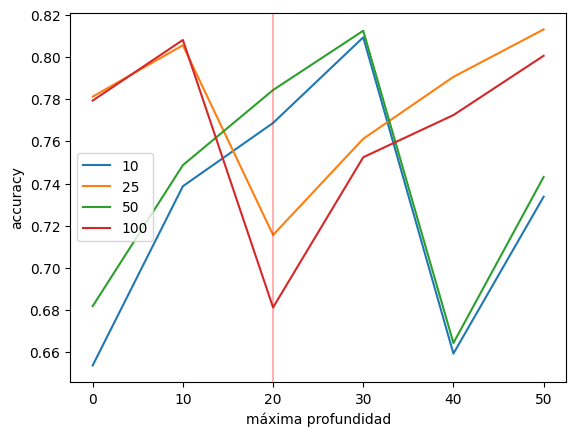

"scores = grid_rndm_forest.cv_results_['mean_test_score']\nmax_depth = [0, 10, 20, 30, 40, 50]\n\n# fem un plot de cada n_estimators amb el seu color\nfor i in range(4):\n    plt.plot(max_depth, scores[i*6:(i+1)*6])\n\nplt.legend(['10', '25', '50', '100'], title = 'n_estimators')\nplt.xlabel('max_depth')\nplt.ylabel('accuracy')\nplt.axvline(grid_rndm_forest.best_params_['max_depth'], color='r', alpha = 0.3)\nplt.show()"

In [19]:
# Gráfica de la búsqueda
params_rndm_forest["max_depth"][0] = 0
plot_gridsearch(grid_rndm_forest, "rndm_forest",params_rndm_forest, "max_depth", "mean_test_score", "máxima profundidad", "accuracy", "n_estimators")

Creación del modelo

In [96]:
# Creación y entrenamiento del modelo considerando la búsqueda anterior
rndm_forest = RandomForestClassifier(n_estimators=100,max_depth=30, random_state=42)
rndm_forest.fit(X_train, y_train)

# Añadido a la lista de modelos
model_list.append((rndm_forest,"rndm_forest"))

time to train: 0.899231seconds


## Predicciones de los modelos con la partición de test

In [71]:
def resultaldos_modelo(clasificador_entrenado: BaseEstimator, modelo_str: str, X_test, y_test) -> float:
    """
    Función que evalúa un clasificador entrenado utilizando datos de test y muestra la precisión (accuracy) y la matriz de confusión.

    Parámetros:
    - clasificador_entrenado: El clasificador ya entrenado.
    - modelo_str: Nombre del modelo como cadena de texto.
    - X_test: Dataset de train.
    - y_test: Variable "target" con los valores reales del test.

    Devuelve:
    - accuracy: La accuracy del modelo (float).
    """
    accuracy = clasificador_entrenado.score(X_test, y_test)
    print(f"Accuracy de {modelo_str}: {accuracy}")
    #name = str(multinomial)

    # Matriz de confusión
    results = clasificador_entrenado.predict(X_test)
    print(classification_report(y_test, results))
    conf_matrix = confusion_matrix(y_test, results, labels=["pos","neg"])

    conf_matrix = ConfusionMatrixDisplay(conf_matrix, display_labels=["pos","neg"])
    conf_matrix.plot()
    plt.savefig(f"./Images/{modelo_str}_conf_matrix.png")
    plt.show()

    return accuracy

Predicciones y resultados (matrices de confusión y métricas)

Accuracy de multinomial: 0.815
              precision    recall  f1-score   support

         neg       0.79      0.86      0.82       201
         pos       0.84      0.77      0.81       199

    accuracy                           0.81       400
   macro avg       0.82      0.81      0.81       400
weighted avg       0.82      0.81      0.81       400



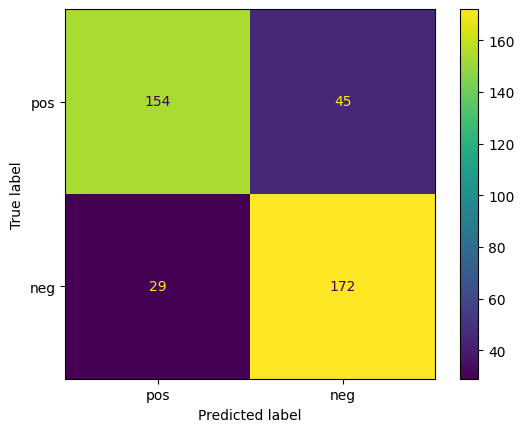

Accuracy de SVC: 0.8
              precision    recall  f1-score   support

         neg       0.79      0.82      0.80       201
         pos       0.81      0.78      0.80       199

    accuracy                           0.80       400
   macro avg       0.80      0.80      0.80       400
weighted avg       0.80      0.80      0.80       400



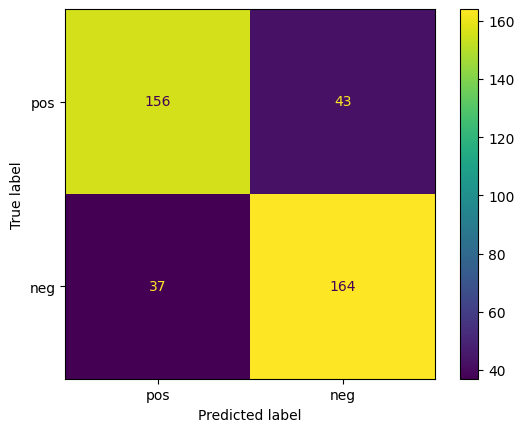

Accuracy de log_reg: 0.8275
              precision    recall  f1-score   support

         neg       0.83      0.83      0.83       201
         pos       0.82      0.83      0.83       199

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



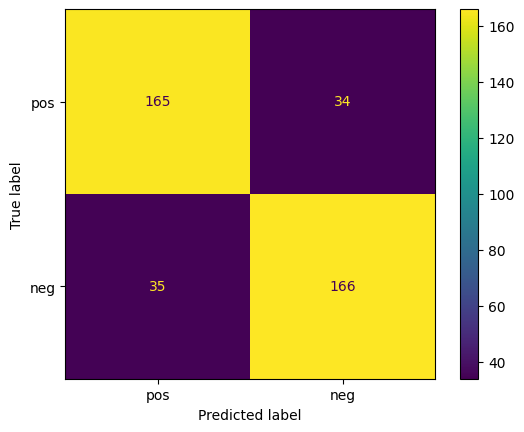

Accuracy de rndm_forest: 0.83
              precision    recall  f1-score   support

         neg       0.85      0.81      0.83       201
         pos       0.81      0.85      0.83       199

    accuracy                           0.83       400
   macro avg       0.83      0.83      0.83       400
weighted avg       0.83      0.83      0.83       400



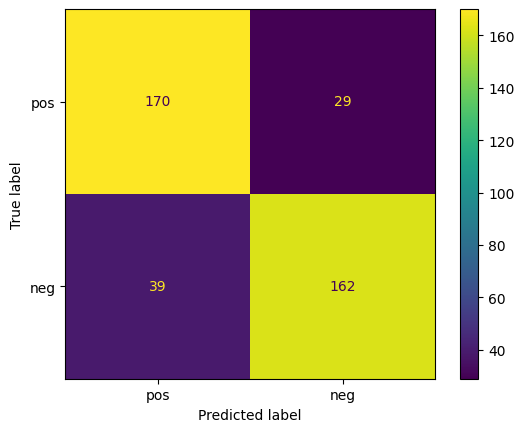

In [72]:
scores = {}

for modelo, modelo_str in model_list:
    scores[modelo_str] = resultaldos_modelo(modelo, modelo_str, X_test, y_test)

Tabla con "accuracy"s de los modelos

In [68]:
df = pd.DataFrame(scores, index=[0])
# set the first row name as "accuracy"
df = df.rename(index={0: "Accuracy:"})
# change the fourth column name to Random forest
#df = df.rename(columns={str(classifier): "RandomForest(n = 25)"})
df.head(1)


,multinomial,SVC,log_reg,rndm_forest
Accuracy:,0.815,0.8,0.8275,0.83


Gráfica de la tabla previa

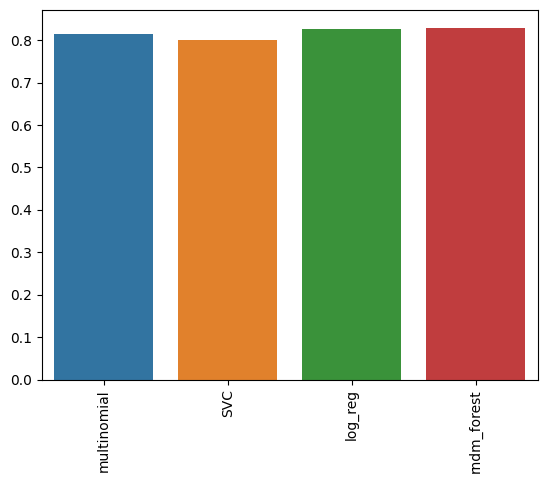

In [69]:
# make a barplot to compare scores of df
sns.barplot(data=df)
# put the labels diagonally
plt.xticks(rotation=90)
plt.show()